In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import mlflow
import pytorch_lightning as pl
from pytorch_lightning.utilities.cloud_io import load as pl_load


In [4]:
from src.rot_utils import *
from src.model import HemelingNet, HemelingRotNet
from src.classifier_net import BinaryClassifierNet, ExportValidation
from run_train import load_dataset, parse_config, setup_model

In [5]:
EXP = '/home/gaby/mlflow/mlruns/4/5160045012be4d76af5ecae8ec6f919a/artifacts/'
cfg = parse_config(EXP+'cfg_extended.yaml')
#cfg.training['dataset-file'] = '/home/gaby/These/src/Fundus/RotInvariance/3-Git/vessels.h5'
trainD, validD, testD = load_dataset(cfg)
cfg['script-arguments']['gpus']='0'

In [6]:
model = setup_model(cfg.model)
net = BinaryClassifierNet(model=model)
state_dict = pl_load(EXP+'best-val-roc.ckpt'.format(25), map_location='cuda:0')['state_dict']
net.load_state_dict(state_dict)
net.eval().cuda()
None

In [6]:
for d in testD['MESSIDOR']:
    break

In [7]:
THETA = 24
x = torch.from_numpy(rotate(d['x'][0].numpy(), THETA)).cuda()

In [8]:
features = {}
def log_f(name):
    def hook(self, inputs, outputs):
        features[name] = outputs.detach().cpu().numpy()
    return hook
net.model.conv1.relu.register_forward_hook(log_f('conv1'))
net.model.conv2.relu.register_forward_hook(log_f('conv2'))
net.model.conv3.relu.register_forward_hook(log_f('conv3'))
net.model.conv4.relu.register_forward_hook(log_f('conv4'))
net.model.conv10.relu.register_forward_hook(log_f('conv10'))

In [9]:
yhat = net(x)
yhat = yhat.detach().cpu().numpy()
yhat = unrotate(yhat, THETA)

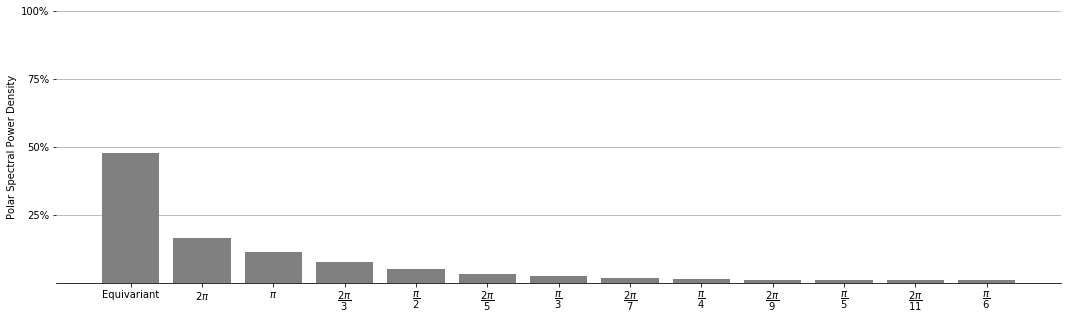

In [10]:
_ = spectral_power(yhat, plot=True)

In [11]:
features = {k: unrotate(v, THETA) for k,v in features.items()}

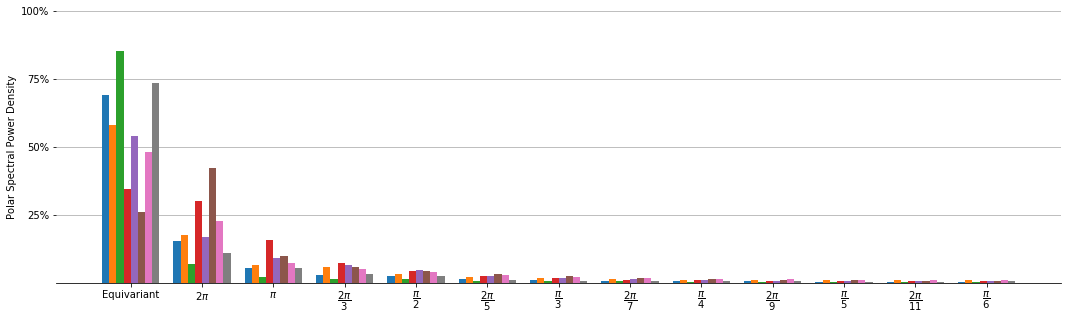

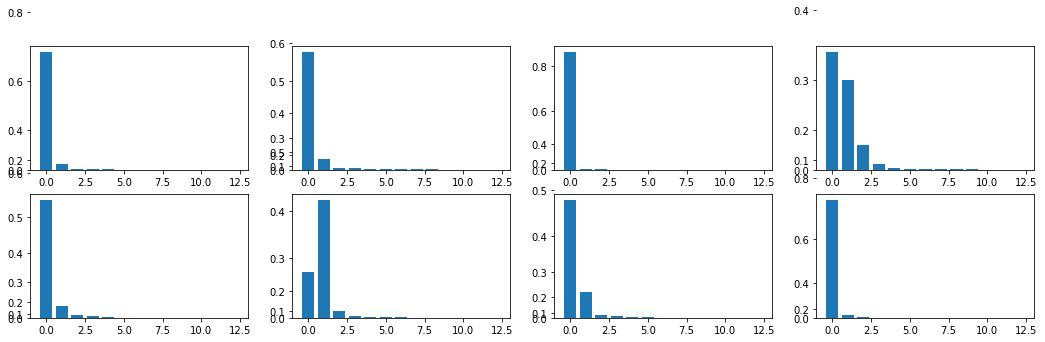

In [12]:
spe = spectral_power(features['conv1'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[0:len(spe)//2+1,i]
    y = y/y.sum()
    x = np.arange(0,len(spe)//2+1)
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

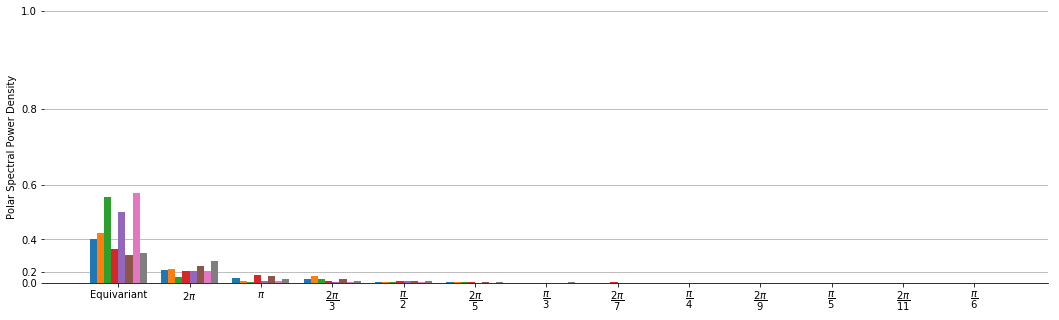

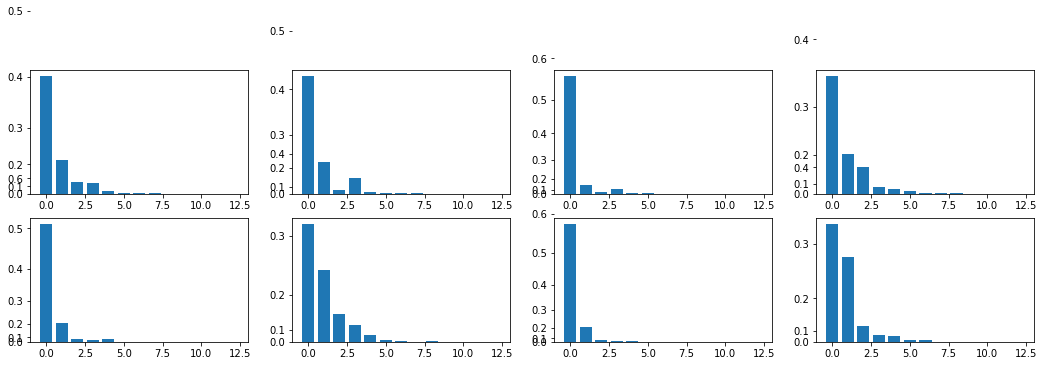

In [13]:
W = net.model.conv1.conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot='sqr', split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[0:len(spe)//2+1,i]
    y = y/y.sum()
    x = np.arange(0,len(spe)//2+1)
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

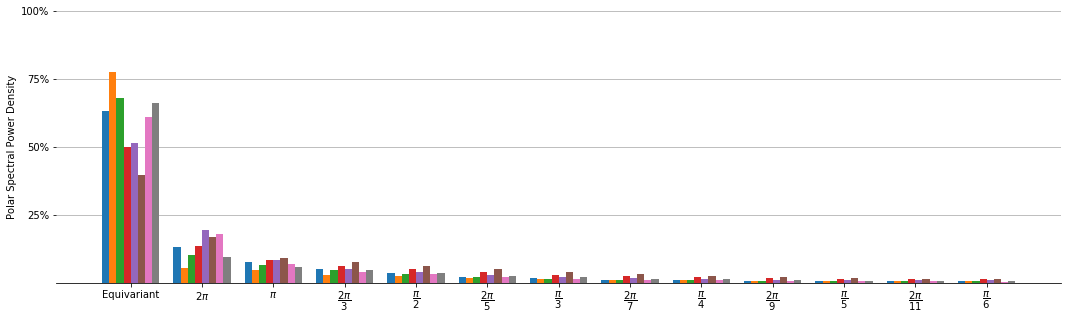

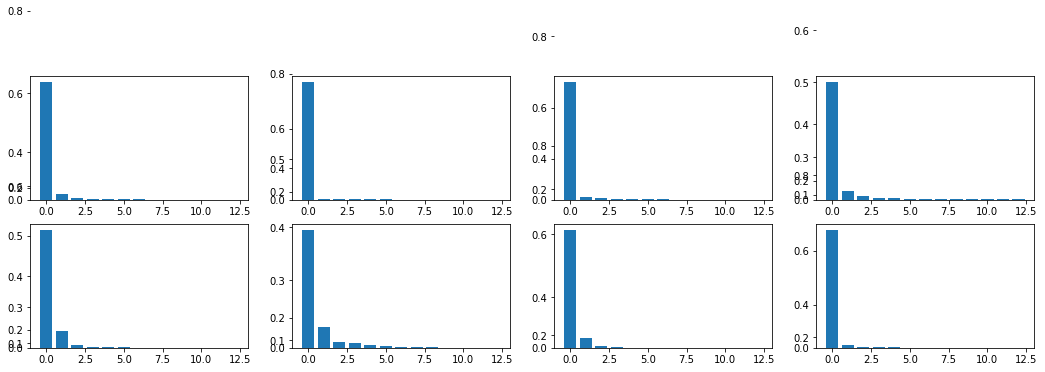

In [14]:
spe = spectral_power(features['conv2'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[0:len(spe)//2+1,i]
    y = y/y.sum()
    x = np.arange(0,len(spe)//2+1)
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

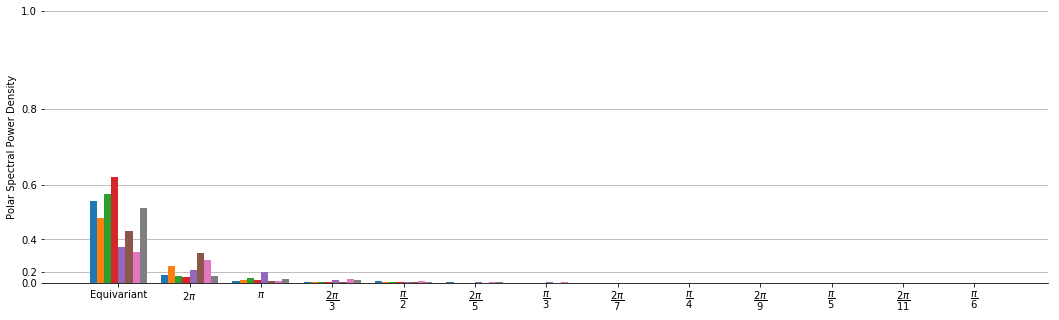

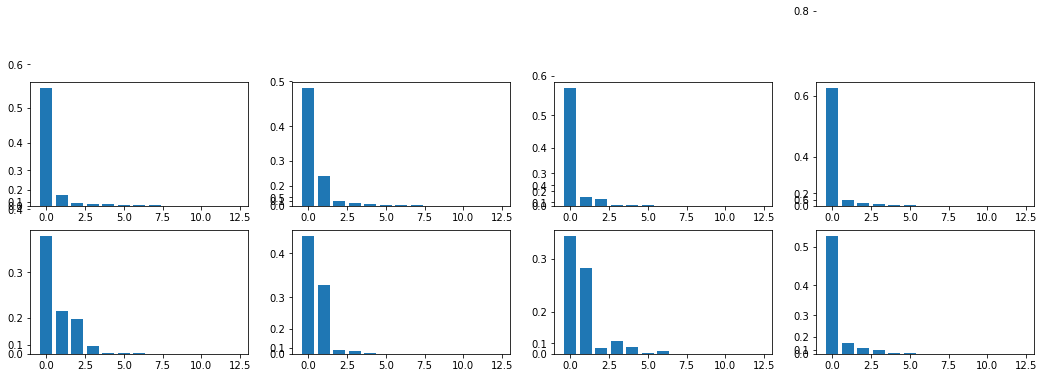

In [15]:
W = net.model.conv2.conv.weight.detach().cpu().numpy()
spe = polar_spectral_power(W, theta=24, plot='sqr', split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[0:len(spe)//2+1,i]
    y = y/y.sum()
    x = np.arange(0,len(spe)//2+1)
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

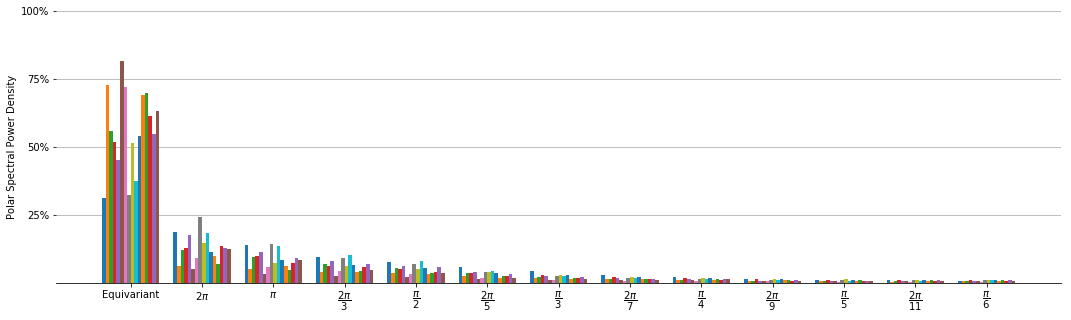

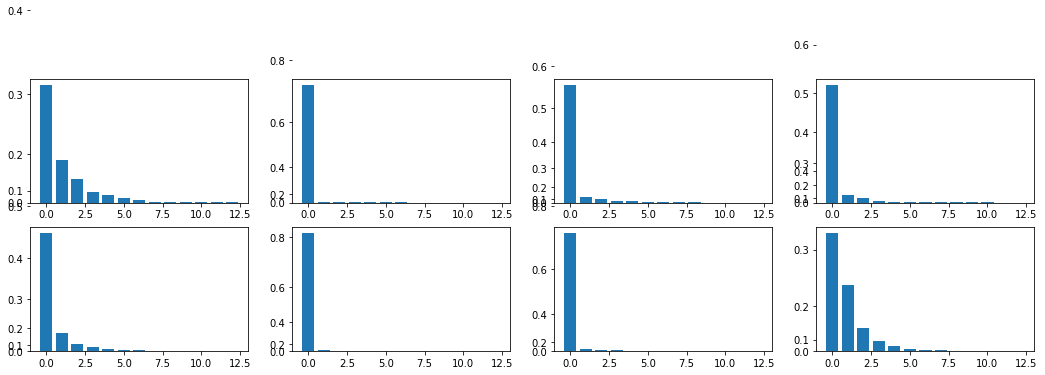

In [16]:
spe = spectral_power(features['conv3'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[0:len(spe)//2+1,i]
    y = y/y.sum()
    x = np.arange(0,len(spe)//2+1)
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

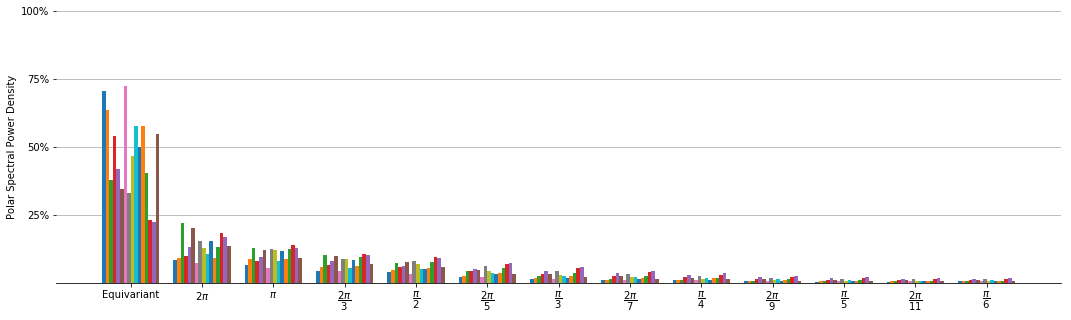

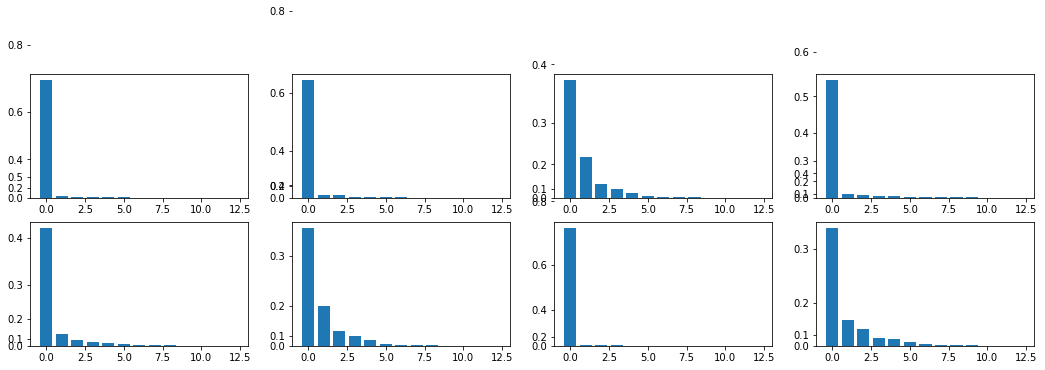

In [17]:
spe = spectral_power(features['conv4'], plot=True, split='normed')

fig, axs = plt.subplots(2,4)
for i in range(8):
    y = spe[0:len(spe)//2+1,i]
    y = y/y.sum()
    x = np.arange(0,len(spe)//2+1)
    ax = axs[i//4,i%4]
    ax.bar(x,y)
    ax.set_yscale('sqr')

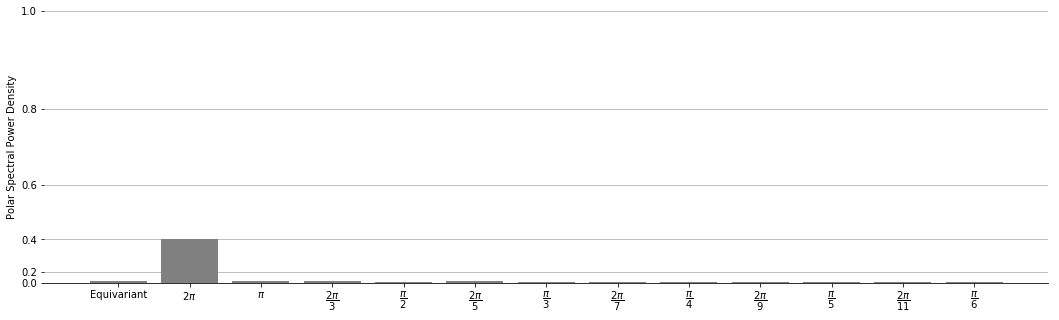

In [18]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter

grad = np.matmul(np.linspace(-1,1,3)[:,None],np.ones((1,3)))
noise = np.random.uniform(0,1,size=(100,100))
noise = gaussian_filter(noise, 3)
noise = rotate(noise, 24)
r = np.stack([convolve2d(_, grad) for _ in noise])
r = unrotate(r, 24)
spe = spectral_power(r, plot='sqr')

Equivariant features: 99/128


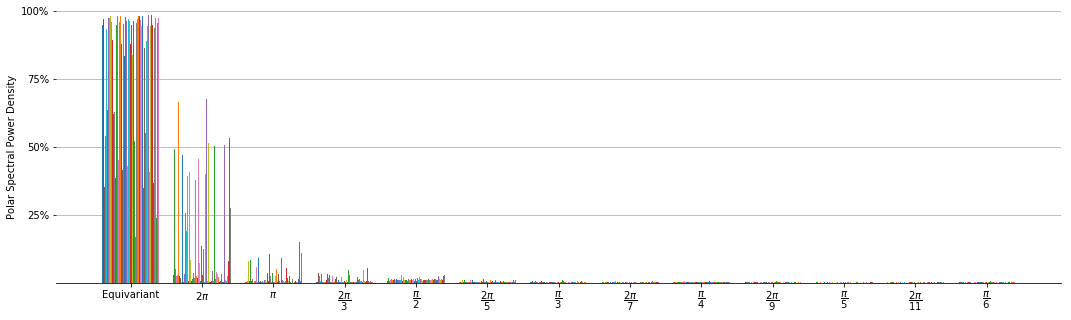

In [19]:
spe = spectral_power(features['conv10'], plot=True, split='normed')
spe = spe / spe.sum(axis=0)
print(f"Equivariant features: {(spe[0]>=.5).sum()}/{spe.shape[1]}")

## Steerable Filters

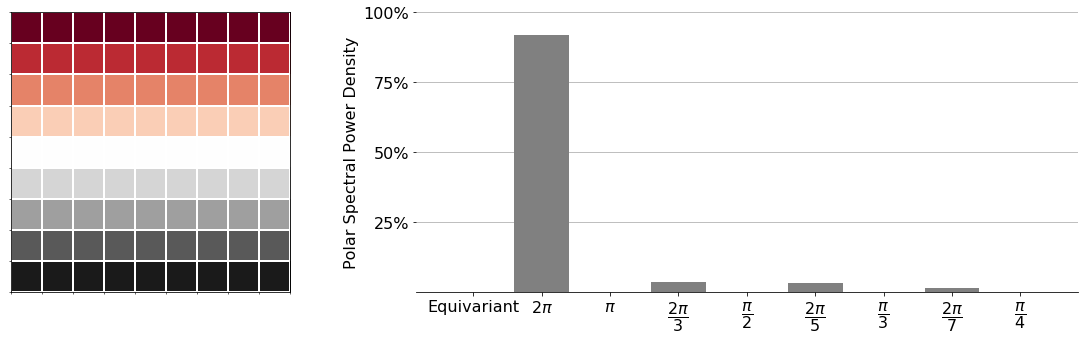

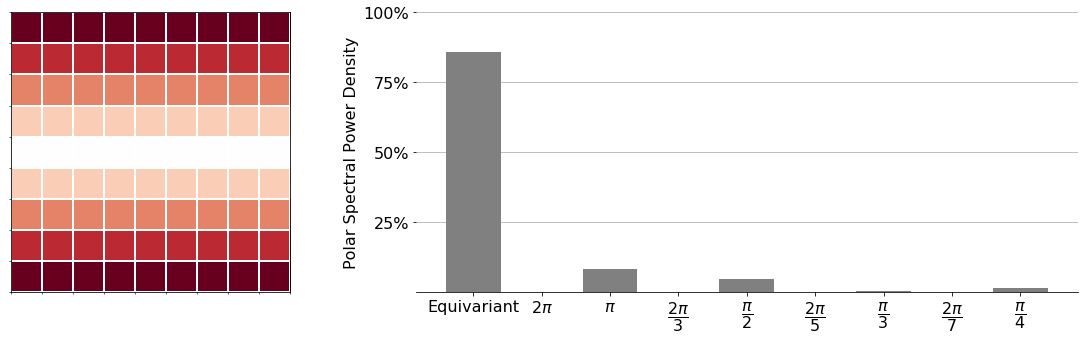

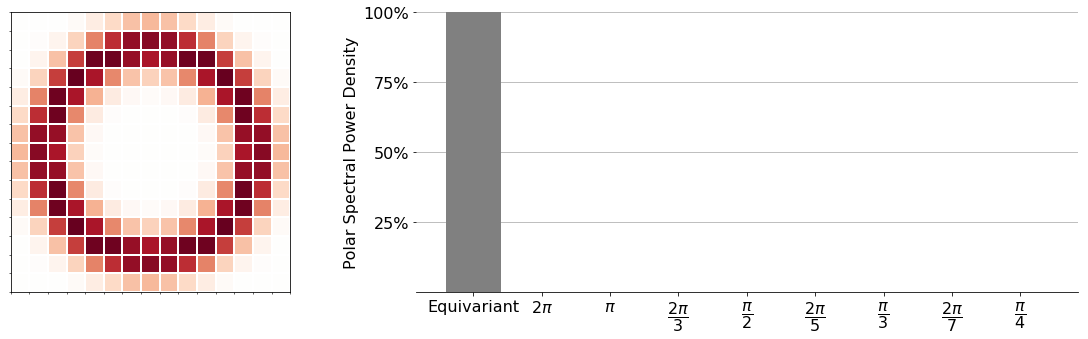

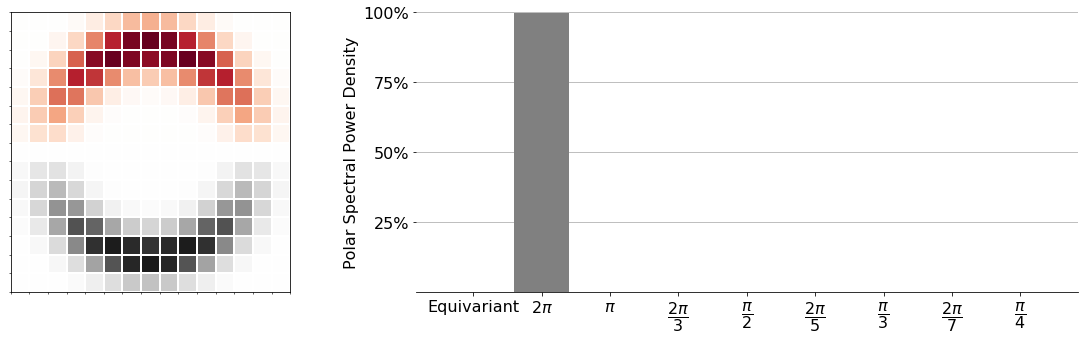

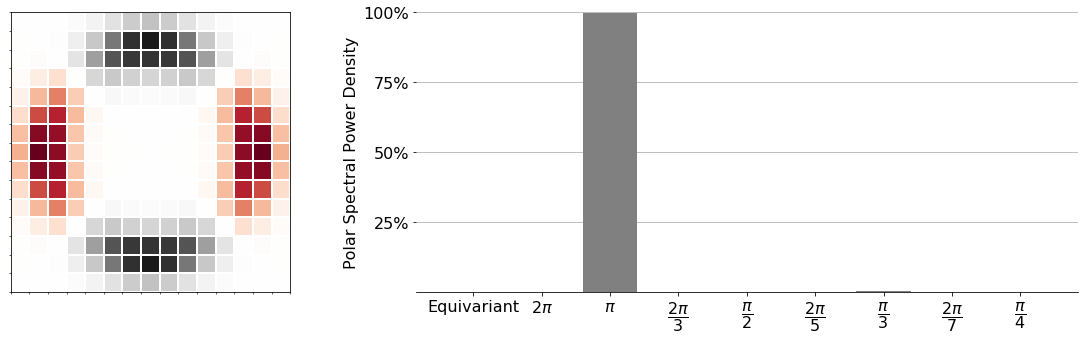

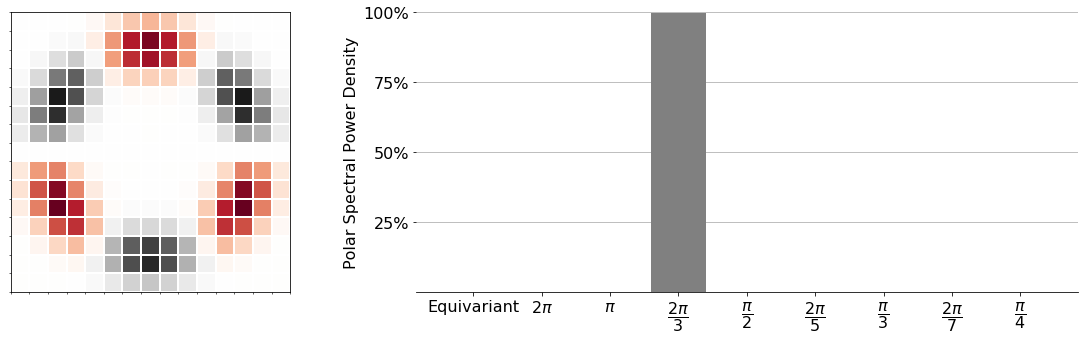

In [20]:
plt.rcParams.update({'font.size': 16})
F0a = np.ones((1,9))*np.arange(-4,5)[:, np.newaxis]
plot_filter(np.real(F0a), axis=False, spd=True)
F0b = np.ones((1,9))*-np.abs(np.arange(-4,5)[:, np.newaxis])
plot_filter(np.real(F0b), axis=False, spd=True)

F0 = radial_steerable_filter(15, k=0,r=6, std=1)
plot_filter(-np.real(F0), axis=False, spd=True)
F1 = radial_steerable_filter(15, k=1,r=6, std=1)
plot_filter(np.real(F1), axis=False, spd=True)
F2 = radial_steerable_filter(15, k=2,r=6, std=1)
plot_filter(np.real(F2), axis=False, spd=True)
F3 = radial_steerable_filter(15, k=3,r=6, std=1)
plot_filter(np.real(F3), axis=False, spd=True)

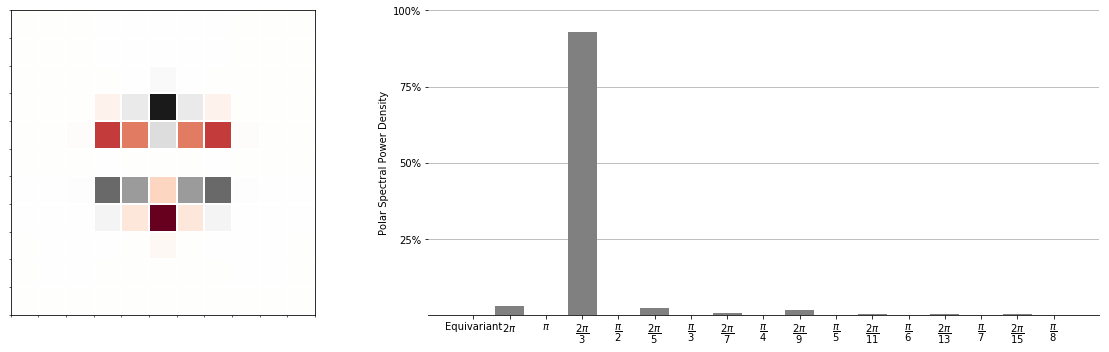

In [99]:
F0 = radial_steerable_filter(11, k=3,r=2, std=.5)
plot_filter(-np.real(F0), axis=False, spd=32)

In [63]:
with np.printoptions(precision=3, suppress=True):
    print(F0)

[[0.011+0.j 0.105+0.j 0.011+0.j]
 [0.105+0.j 1.   +0.j 0.105+0.j]
 [0.011+0.j 0.105+0.j 0.011+0.j]]
